# Melanoma  Skin Cancer Detection Case Study

**Project Objective:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## 1.0 Importing all the important libraries 

In [16]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [17]:
## Using the data by mounting the google drive :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This dataset has about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [18]:
# Defining the path for train images and test images
train_data_path="gdrive/My Drive/CNN Assignment/Train/"
test_data_path="gdrive/My Drive/CNN Assignment/Test/"
data_dir_train = pathlib.Path(train_data_path)
data_dir_test = pathlib.Path(test_data_path)

In [19]:
#Counting the train and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


We can see that output of counting that train image are 2239 and test image are 118 so total 2357 images of total 9  categories of skin cancer.

### 2.0 Data set Preparation 

In [20]:
#Define some parameters for the loader as given in custom code
batch_size = 32
img_height = 180
img_width = 180

We will Use 80% of the images for training, and 20% for validation as given in custom code.

## 2.1 Creation of Train Data set with predifened seed in custom code.

In [21]:
# Load the training dataset from the specified directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, #directory
    labels='inferred', # to infer the labels from subdirectory names
    label_mode='categorical', # to use categorical labels
    class_names=None, # for class names will be inferred from subdirectory names
    color_mode='rgb', # to use RGB color mode
     batch_size=32, # batch size for training
     image_size=(180,180), # resize images to this size
    shuffle=True, # shuffle the training data
    seed=123, # use a fixed random seed =123 as given in problem
    validation_split=0.2, # split 20% of the data for validation
    subset='training', # use the subset for training
    interpolation='bilinear', # use bilinear interpolation for resizing
    follow_links=False, # do not follow symbolic links
    smart_resize=False # do not use smart resizing
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


### 2.2 Creation of validation data set 

In [22]:
# Load the validation dataset from the specified directory
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',  # to infer the labels from subdirectory names
    label_mode='categorical',  # to use categorical labels
    class_names=None,  # for class names will be inferred from subdirectory names
    color_mode='rgb',  # to use RGB color mode
    batch_size=32,  # batch size for training
    image_size=(180, 180),  # resize images to this size
    shuffle=True,  # shuffle the training data
    seed=123,  # use a fixed random seed =123 as given in problem
    validation_split=0.2,  # split 20% of the data for validation
    subset='validation',  # use the subset for validation
    interpolation='bilinear',  # use bilinear interpolation for resizing
    follow_links=False,  # do not follow symbolic links
    smart_resize=False  # do not use smart resizing
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### 2.3 List out all the classes of skin cancer

In [23]:
# To List out all the classes of skin cancer and store them in a list in aplhabatical order as given in custom code.
class_names = train_ds.class_names 
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 3.0  Visualizing the image data in one instance of all the nine classes present in the dataset 

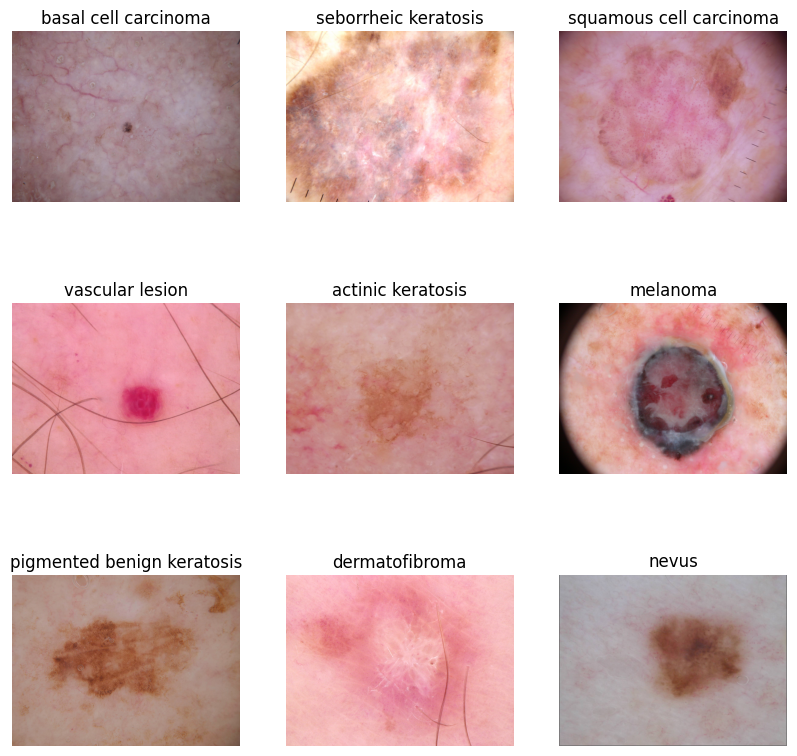

In [24]:
import matplotlib.pyplot as plt
numr = 0
fig = plt.figure(figsize=(10, 10))

for dirpath, dirnames, filenames in os.walk(str(train_data_path)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3, 3, numr+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        numr += 1
        if numr == 9:
            break
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Model -1 (This is intial base model)

### 4.1 Creating the base model 

In [26]:
# Define input shape of the image
input_shape = (img_height, img_width, 3)

# Create the model
model = Sequential()

# Add rescaling layer to scale input pixels between 0 and 1
model.add(Rescaling(scale=1./255., offset=0.0, input_shape=input_shape))

# Add convolutional layers with relu activation and max pooling
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.12))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.12))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add fully connected layers with relu activation and dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(9, activation='softmax'))

### 4.2 Compiling the base model 

In [27]:
# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

###  4.3 Training the base model with 20 epochs

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 22s 141ms/step - loss: 2.9741 - accuracy: 0.2238 - val_loss: 1.8864 - val_accuracy: 0.3781
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.7616 - accuracy: 0.3828 - val_loss: 1.6240 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6158 - accuracy: 0.4369 - val_loss: 1.6558 - val_accuracy: 0.4206
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.5238 - accuracy: 0.4732 - val_loss: 1.4038 - val_accuracy: 0.5548
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3482 - accuracy: 0.5257 - val_loss: 1.3607 - val_accuracy: 0.5548
Epoch 6/20
56/56 [==============================] - 3s 48ms/step - loss: 1.3268 - accuracy: 0.5324 - val_loss: 1.3537 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.2240 - accuracy: 0.5714 - val_loss: 1.3729 - val_accuracy: 0.5324
Epoch 8/20


In [29]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

###  4.4 Visualization of  training results of base model

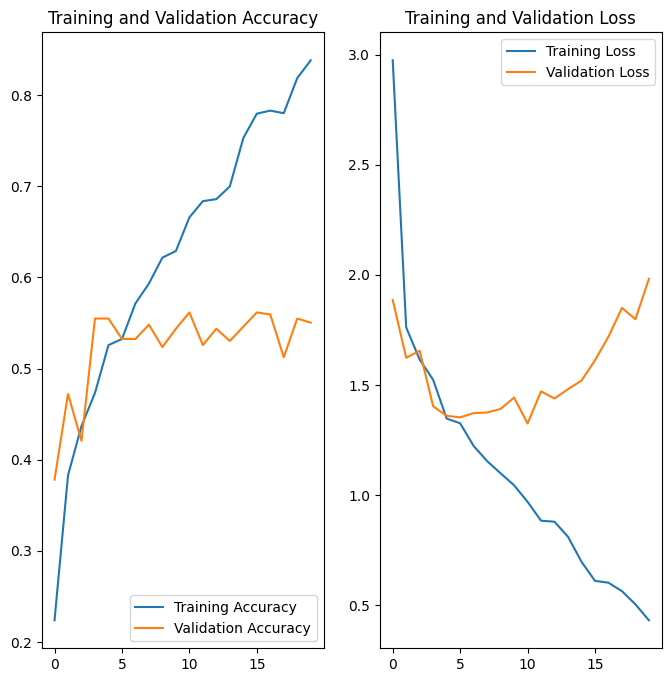

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###  4.5 Observations from visulization of data of base model-1

-  The accuracy of the base model for the **Training data set** is approx **83%** . But the **Validation accuracy** is not near to the training accuracy. 
-  It is only at approx **55%**
-  This is also be indicative of some **Overfit** in the model.
-  We can add some `Dropout` layers and then we will check that overfitting getting solved or not after adding more dropout layer?

###  5. Model-2 (With more dropout layer)

###  5.1 Creating the Model with adding more dropout layer

In [45]:
# Define input shape of the image
input_shape = (img_height, img_width, 3)

# Create the model
model_2 = Sequential()

# Add rescaling layer to scale input pixels between 0 and 1
model_2.add(Rescaling(scale=1./255., offset=0.0, input_shape=input_shape))

# Add convolutional layers with relu activation and max pooling
model_2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.65))

model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.65))

# Flatten the output of the convolutional layers
model_2.add(Flatten())

# Add fully connected layers with relu activation and dropout
model_2.add(Dense(105, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(9, activation='softmax'))

### 5.2 Compiling the model-2 (with more drop out layer)

In [46]:
# Compile the model with categorical cross-entropy loss and Adam optimizer
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

###  5.3 Training the model after adding more dropout layer

In [47]:
##  train our model for 20 epochs
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 55ms/step - loss: 4.4732 - accuracy: 0.1769 - val_loss: 2.1845 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 51ms/step - loss: 2.1095 - accuracy: 0.2059 - val_loss: 2.1628 - val_accuracy: 0.2595
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 2.0161 - accuracy: 0.2662 - val_loss: 2.1097 - val_accuracy: 0.3020
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 1.9238 - accuracy: 0.3315 - val_loss: 2.0482 - val_accuracy: 0.3378
Epoch 5/20
56/56 [==============================] - 3s 51ms/step - loss: 1.8371 - accuracy: 0.3555 - val_loss: 1.9315 - val_accuracy: 0.3803
Epoch 6/20
56/56 [==============================] - 3s 51ms/step - loss: 1.7919 - accuracy: 0.3767 - val_loss: 1.9044 - val_accuracy: 0.4049
Epoch 7/20
56/56 [==============================] - 3s 50ms/step - loss: 1.7136 - accuracy: 0.3884 - val_loss: 1.7940 - val_accuracy: 0.3937
Epoch 8/20
56

###  5.4 Visualizing the results of 2nd Model(adding more drop out layer)

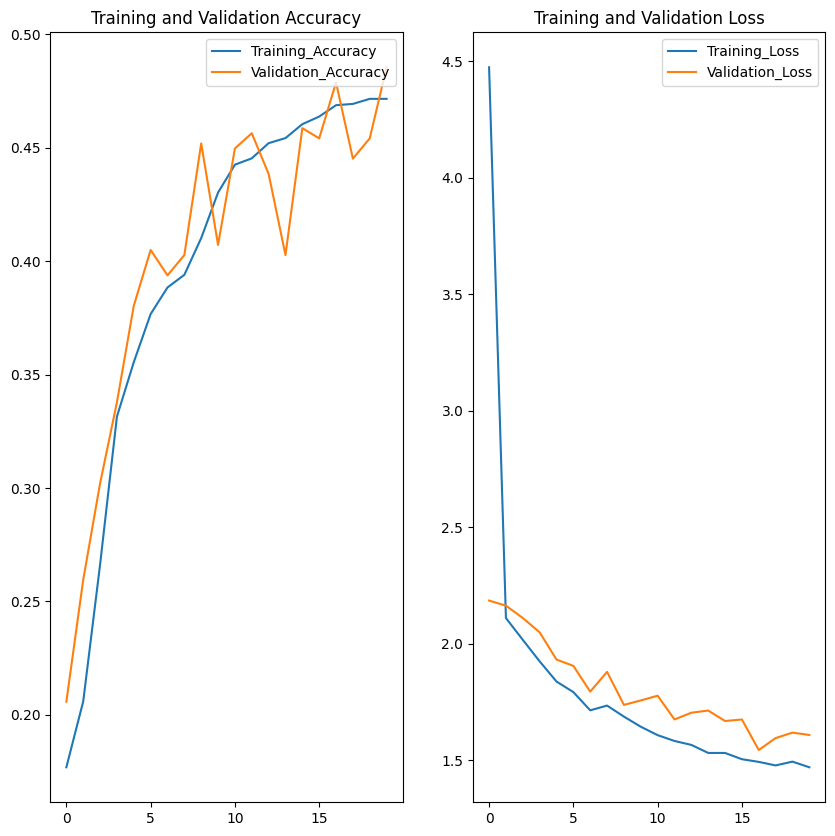

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training_Accuracy')
plt.plot(epochs_range, val_acc, label='Validation_Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training_Loss')
plt.plot(epochs_range, val_loss, label='Validation_Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 5.5 Observations after adding dropout layer

-  The model accuracy for **Train data set** has dropped to nearly **48%**.
-  The accuracy for the **Validation set** is at **48%**.
-  This is a much better model compared to the previous model as there seems to be **No  Overfit** with the training accuracy **48%** and validation accuracy at **48%**. 
-as both the accuracy approximatly same it means adding dropout layer somewhat solved the issue of overfitting

### 6.0 Data Augmentation(with tensor flow augumentation)

### 6.1 Specifying the Augmentation with tensor flow keras

In [49]:
# Define the data augmentation techniques as a sequential model
augmented_data= tf.keras.Sequential([
  # Randomly flip the input images horizontally and vertically
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  # Randomly rotate the input images by a certain angle (up to 25% of the total width/height)
  layers.experimental.preprocessing.RandomRotation(0.25)
])

###  6.2 Visualizing the Augmented image Data

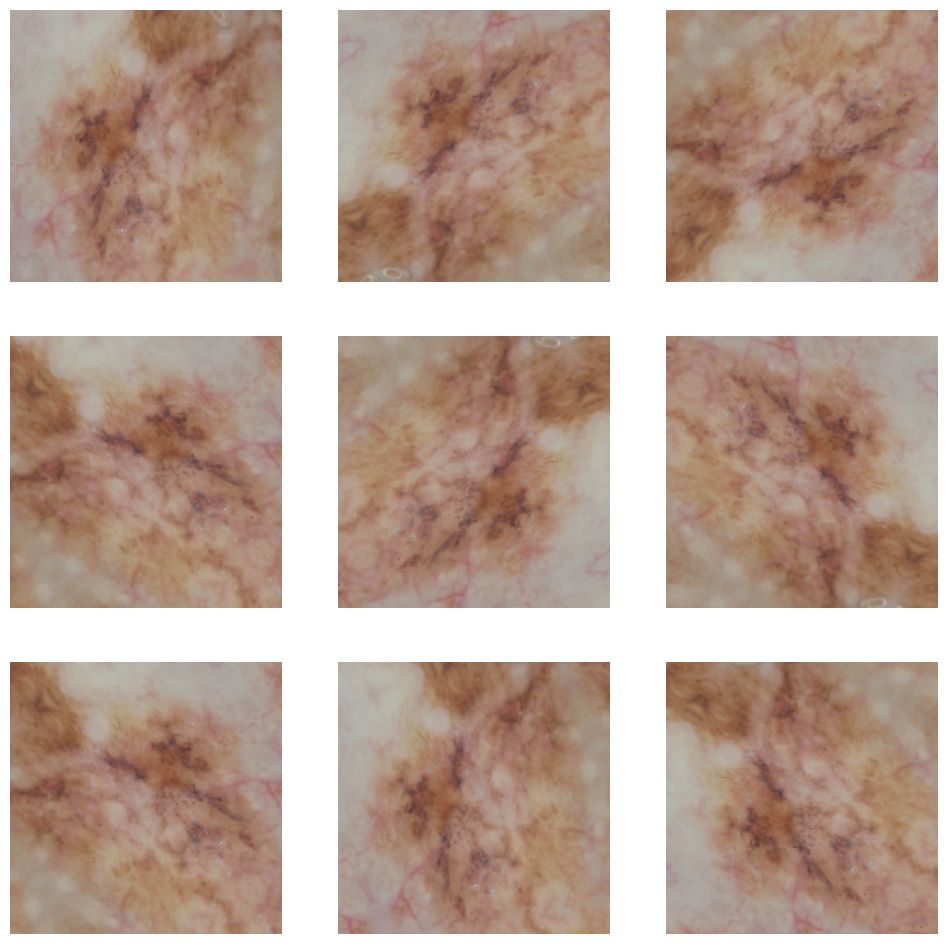

In [51]:
img, label = next(iter(train_ds))
img=np.array(img,np.int32)  
plt.figure(figsize=(12, 12))
for i in range(9):
  augmented_images = augmented_data(img)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image_1=np.array(augmented_images[0],np.int32)  
  plt.imshow((augmented_image_1))
  plt.axis("off")

## 7.0 Model 3 (Tensorflow augumentation)

###  7.1 Creating the Model-3 with augumentation

In [55]:
Augmented_model = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0),         
    augmented_data,
    
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.65),
    
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.65),
    
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.65),
    
    Flatten(),
    Dense(105, activation='relu'),
    Dropout(0.26),
    Dense(9, activation='softmax')
])

### 7.2 Compiling the augumnted model (model-3)

In [56]:
#comlining with adam optimiser and loss function categorical crossentropy
Augmented_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

### 7.3 Training the model after augumentation with tensor flow

In [57]:
## train our model for 20 epochs on augumnted data
epochs = 20
history = Augmented_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 115ms/step - loss: 2.1521 - accuracy: 0.1775 - val_loss: 2.0461 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 6s 109ms/step - loss: 2.0325 - accuracy: 0.1925 - val_loss: 2.0373 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 6s 110ms/step - loss: 2.0241 - accuracy: 0.2081 - val_loss: 2.0173 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 6s 109ms/step - loss: 2.0289 - accuracy: 0.1920 - val_loss: 2.0258 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 6s 110ms/step - loss: 2.0302 - accuracy: 0.2098 - val_loss: 2.0255 - val_accuracy: 0.2036
Epoch 6/20
56/56 [==============================] - 6s 111ms/step - loss: 1.9852 - accuracy: 0.2171 - val_loss: 1.8697 - val_accuracy: 0.3445
Epoch 7/20
56/56 [==============================] - 6s 112ms/step - loss: 1.8547 - accuracy: 0.3209 - val_loss: 1.7007 - val_accuracy: 0.3937
Epoch 

### 7.4 Visualizing the results after augumentaion with tensor flow

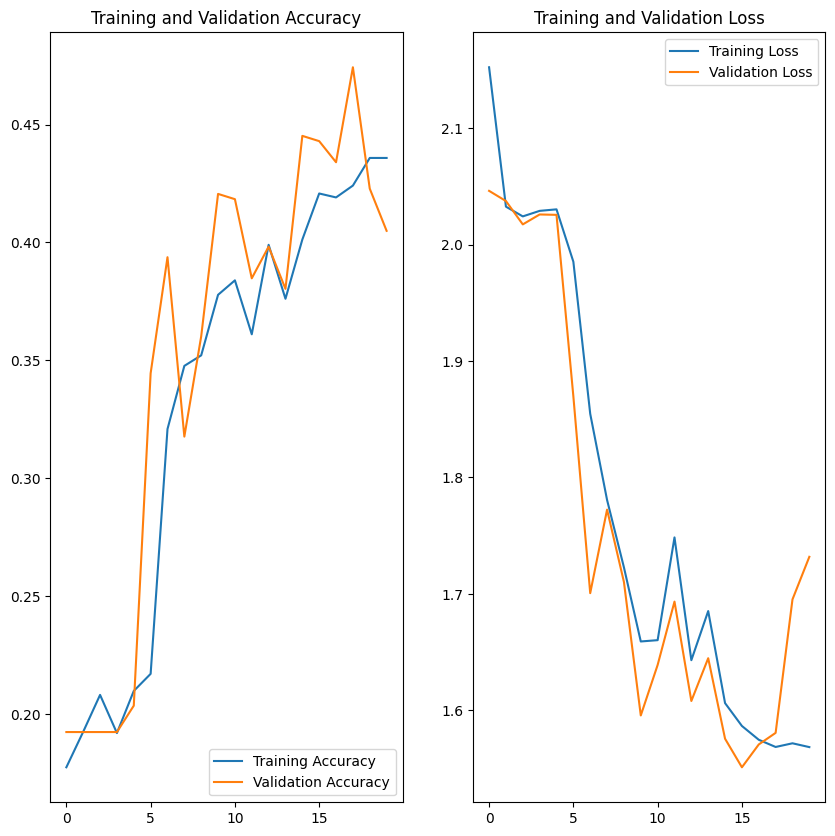

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 7.5  Observations of model-3

-  The model accuracy for **Train data set** has gone up to nearly **43%**.
-  The accuracy for the **Validation set** is also at **40%**.
-  This is a much better model compared to the previous two models as there seems to be **No Overfit** with the training accuracy **43%** and validation accuracy at **40%**.
-**Data Augmentation**has improved the model performance but we will use python augumentor to solve class imbalance

###8.0 Checking for class imbalnce

In [59]:
for i in class_names:
    directory_1 =train_data_path+i+'/'
    class_directory = pathlib.Path(directory_1)
    lnth=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {lnth} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


-**Results of class imbalnce**  
The samples of various classes are equally distributed
-  There is a significant **Class Imbalance obsereved**
-  The class Seborrheic Keratosis` has **77** samples only
-  The class that dominates  is `Pigmented Benign Keratosis` with sample size of **462**. 
-we need to deal with this class imbalance definitely

## 9. Using Augmentor library for Class Imbalance Treatment 

###  9.1 Installing Augmentor <a name='no9.1' />

In [60]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


### 9.2 Using Augmentor <a name='no9.2' />

In [61]:
path_to_training_dataset=train_data_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/CNN Assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA84BFC3880>: 100%|██████████| 500/500 [00:21<00:00, 23.66 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/CNN Assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA84AF5CEE0>: 100%|██████████| 500/500 [00:19<00:00, 25.47 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/CNN Assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA84BFD4580>: 100%|██████████| 500/500 [00:21<00:00, 23.50 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/CNN Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FA8EC02C910>: 100%|██████████| 500/500 [01:41<00:00,  4.95 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/CNN Assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FA8EC08A1C0>: 100%|██████████| 500/500 [01:27<00:00,  5.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/CNN Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA84AF21100>: 100%|██████████| 500/500 [00:20<00:00, 24.43 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/CNN Assignment/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FA866413E20>: 100%|██████████| 500/500 [00:46<00:00, 10.67 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/CNN Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA8EC081C10>: 100%|██████████| 500/500 [00:20<00:00, 24.36 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/CNN Assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA8EC2A4430>: 100%|██████████| 500/500 [00:19<00:00, 25.13 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [62]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Total image after augumentor are 4500

In [66]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [67]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [68]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

### 9.3Data in different classes after applying the class balanace technique

In [69]:
for i in class_names:
    directory =train_data_path+i+'/'
    directory_out =train_data_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_o=len(list(class_directory_out.glob('*.jpg')))
    length_total=length+length_o
    print(f'{i} has {length_total} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


We can see from above that augumentor helped to solve the class imbalance issue

### 9.4 Observations after applying the augumentor

-The Python Augmentor has  **helped us to decrease the imbalance** in class images and that we can be viewed from above that all classes are now have somewhat similar number of images

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process of the model.

##  10. Modelling with Augmented Data with python augumentor(Model-4)

In [70]:
batch_size = 32
img_height = 180
img_width = 180

### 10.1 Creating the Train Data Set augumented images

In [71]:
# Set the path to the directory containing the training data
data_dir_train = train_data_path

# Use the TensorFlow Keras utility function to create a dataset from the image files in the directory.
# The dataset will be used to train an image classification model.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train, # The path to the training data directory
  seed=123, # The seed used for shuffling the data
  label_mode='categorical', # Set the label mode to categorical (one-hot encoding)
  validation_split=0.2, # Use 20% of the data for validation
  subset='training', # Specify that this dataset will be used for training
  image_size=(img_height, img_width), # Set the size of the images
  batch_size=batch_size # Set the batch size
)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### 10.2 Creating the Validation Data Set of augumnted images

In [72]:
# Set the path to the directory containing the training data
data_dir_train = train_data_path

# Use the TensorFlow Keras utility function to create a dataset from the image files in the directory.
# The dataset will be used to validate an image classification model.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train, # The path to the training data directory
  seed=123, # The seed used for shuffling the data
  label_mode='categorical', # Set the label mode to categorical (one-hot encoding)
  validation_split=0.2, # Use 20% of the data for validation
  subset='validation', # Specify that this dataset will be used for validation
  image_size=(img_height, img_width), # Set the size of the images
  batch_size=batch_size # Set the batch size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## 11. Model -4 (After using augumntor and balancing the class)

### 11.1 Creating the Model-4

In [73]:
# Define input shape of the image
input_shape = (img_height, img_width, 3)

# Create the model
final_model= Sequential()

# Add rescaling layer to scale input pixels between 0 and 1
final_model.add(Rescaling(scale=1./255., offset=0.0, input_shape=input_shape))

# Add convolutional layers with relu activation and max pooling
final_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
final_model.add(MaxPooling2D(pool_size=(2, 2)))
final_model.add(Dropout(0.11))

final_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
final_model.add(MaxPooling2D(pool_size=(2, 2)))
final_model.add(Dropout(0.11))

# Flatten the output of the convolutional layers
final_model.add(Flatten())

# Add fully connected layers with relu activation and dropout
final_model.add(Dense(128, activation='relu'))
final_model.add(Dropout(0.24))
final_model.add(Dense(9, activation='softmax'))

### 11.2 Compiling the Model-4

In [74]:
#optimizer used as adam
final_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

### 11.3 Training the Model-4 with 30 epochs

In [75]:
#Training the model with 30 epochs
epochs = 30
history = final_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 37s 195ms/step - loss: 2.4924 - accuracy: 0.2266 - val_loss: 1.7392 - val_accuracy: 0.3660
Epoch 2/30
169/169 [==============================] - 36s 206ms/step - loss: 1.5922 - accuracy: 0.3913 - val_loss: 1.5752 - val_accuracy: 0.4232
Epoch 3/30
169/169 [==============================] - 35s 200ms/step - loss: 1.4174 - accuracy: 0.4616 - val_loss: 1.4675 - val_accuracy: 0.4974
Epoch 4/30
169/169 [==============================] - 33s 191ms/step - loss: 1.2599 - accuracy: 0.5263 - val_loss: 1.2158 - val_accuracy: 0.5687
Epoch 5/30
169/169 [==============================] - 34s 197ms/step - loss: 1.1342 - accuracy: 0.5799 - val_loss: 1.3396 - val_accuracy: 0.5182
Epoch 6/30
169/169 [==============================] - 33s 190ms/step - loss: 0.9825 - accuracy: 0.6372 - val_loss: 1.0446 - val_accuracy: 0.6162
Epoch 7/30
169/169 [==============================] - 34s 197ms/step - loss: 0.8786 - accuracy: 0.6795 - val_loss: 0.9830 - val_ac

###  11.4 Visualizing the model results 

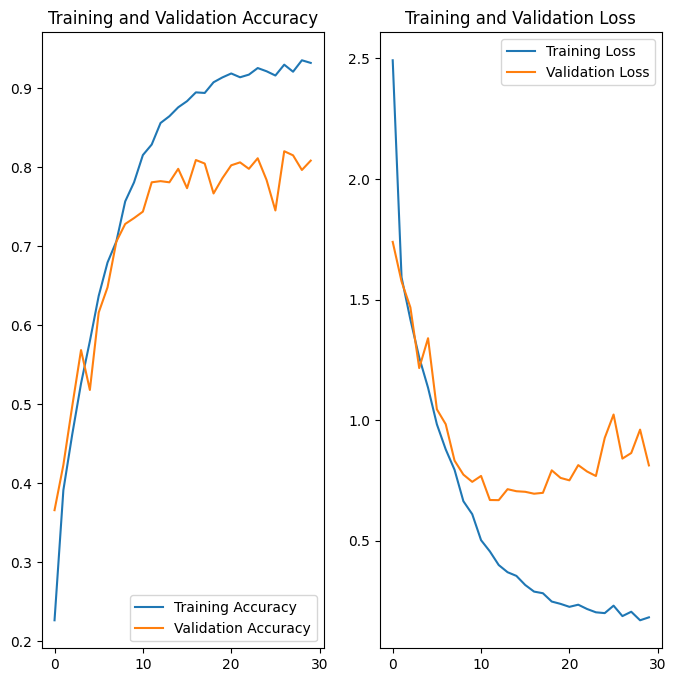

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 11.5 Observations 

-  The training accuracy seems to be nearly **~92%**. 
-  The validation accuracy is nearly **~80%**.
-  Though the model accuracy has improved, the **class rebalance** has helped treat the overfitting to some extent.
-  if add **more epochs and more layers**. we can built much more models
-Out of four models the model with python augumentor has highest training nad validation accuracy and helped to resolved the class imbalance issue.
-We can see that after class rebalance the accurcy differnce is not much and also its increased.